<a href="https://colab.research.google.com/github/PangyourQA/Quant-practice/blob/main/GW1_Stochastic_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import Libraries
import gdown
import pandas as pd
import numpy as np
from scipy.integrate import quad
from scipy.optimize import brute, fmin
import matplotlib.pyplot as plt

In [ ]:
#Define Functions
#Step 1 - Team Member A
def load_excel_from_google_drive(google_drive_link, local_file_path):
    """
    Download an Excel file from Google Drive and load it into a Pandas DataFrame.

    Args:
        google_drive_link (str): The shareable link of the Google Drive file.
        local_file_path (str): The local file path where you want to save the downloaded Excel file.

    Returns:
        pd.DataFrame: A Pandas DataFrame containing the data from the Excel file.
    """
    # Extract the file ID from the Google Drive link
    file_id = google_drive_link.split("/")[-2]

    # Construct the download link
    download_link = f"https://drive.google.com/uc?id={file_id}"

    # Download the Excel file from Google Drive
    gdown.download(download_link, local_file_path, quiet=False)

    # Load the Excel file into a Pandas DataFrame
    df = pd.read_excel(local_file_path)

    return df

# Function to calculate model prices for put options using put-call parity
def calculate_put_model_prices(model_prices, S, K, r, T):
    put_model_prices = []
    for call_price in call_model_prices:
        put_price = call_price - S + K * np.exp(-r * T)
        put_model_prices.append(put_price)
    return put_model_prices

def H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """Characteristic function for Asian call option in Heston (1993) model."""
    c1 = kappa_v * theta_v
    c2 = -np.sqrt(
        (rho * sigma_v * u * 1j - kappa_v) ** 2 - sigma_v ** 2 * (-u * 1j - u ** 2)
    )
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (
        kappa_v - rho * sigma_v * u * 1j - c2
    )
    H1 = r * u * 1j * T + (c1 / sigma_v ** 2) * (
        (kappa_v - rho * sigma_v * u * 1j + c2) * T
        - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))
    )
    H2 = (
        (kappa_v - rho * sigma_v * u * 1j + c2)
        / sigma_v ** 2
        * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T)))
    )
    char_func_value = np.exp(H1 + H2 * v0)
    return char_func_value

def H93_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """Integration function for Asian call option in Heston (1993) model."""
    char_func_value = H93_char_func(u - 1j * 0.5, T, r, kappa_v, theta_v, sigma_v, rho, v0)
    int_func_value = (
        1
        / (u ** 2 + 0.25)
        * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    )
    return int_func_value

def H93_asian_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, N, M, seed_value):
    """Valuation of Asian call option in H93 model via Lewis (2001), with Monte Carlo for Asian option payoff

    Parameters:
    ==========
    S0: float
        Initial stock/index level
    K: float
        Strike price
    T: float
        Time-to-maturity (for t=0)
    r: float
        Constant risk-free short rate
    kappa_v: float
        Mean-reversion factor for variance
    theta_v: float
        Long-run mean of variance
    sigma_v: float
        Volatility of variance
    rho: float
        Correlation between variance and stock/index level
    v0: float
        Initial level of variance
    N: int
        Number of monitoring points for the Asian option
    M: int
        Number of Monte Carlo simulations
    seed_value: int
        Seed for random number generator
    Returns:
    =======
    asian_call_value: float
        Present value of Asian call option
    """
    int_value = quad(
        lambda u: H93_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0),
        0,
        np.inf,
        limit=250,
    )[0]
    # Initialize variables
    np.random.seed(seed_value)
    dt = T / N  # Define time step
    u = np.exp(sigma_v * np.sqrt(dt))  # Define u
    d = np.exp(-sigma_v * np.sqrt(dt))  # Define d
    p = (np.exp(r * dt) - d) / (u - d)  # risk neutral probs
    Asian = np.zeros([M])  # Asian prices
    S = np.zeros([M, N + 1])  # underlying price
    S[:, 0] = S0

    for j in range(0, M):
        random = np.random.binomial(1, p, N + 1)
        Total = S0
        for i in range(1, N + 1):
            if random[i] == 1:
                S[j, i] = S[j, i - 1] * u
                Total = Total + S[j, i]
            else:
                S[j, i] = S[j, i - 1] * d
                Total = Total + S[j, i]

        Asian[j] = np.exp(-r * T)  * max((Total / (N + 1) - K), 0)
        average = np.mean(Asian)

    return average


def H93_error_function(p0):
    """
    Error function for parameter calibration via Lewis (2001) Fourier approach for Heston (1993).
    Parameters:
        kappa_v: float, mean-reversion factor
        theta_v: float, long-run mean of variance
        sigma_v: float, volatility of variance
        rho: float, correlation between variance and stock/index level
        v0: float, initial, instantaneous variance
    Returns:
        MSE: float, mean squared error
    """
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0 = p0
    if kappa_v < 0.0 or theta_v < 0.005 or sigma_v < 0.0 or rho < -1.0 or rho > 1.0:
        return 500.0
    if 2 * kappa_v * theta_v < sigma_v**2:
        return 500.0
    se = []
    for row, option in options.iterrows():
        model_value = H93_asian_call_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            N,
            M,
            seed_value
        )
        se.append((model_value - option["Call"]) ** 2)
    MSE = np.mean(se)  # Calculate the mean squared error correctly
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE

def H93_calibration_full():
    """Calibrates Heston (1993) stochastic volatility model to market quotes."""
    # First run with brute force (scan sensible regions for faster convergence)
    p0 = brute(
        H93_error_function,
        (
            (2.5, 10.6, 5.0),  # kappa_v
            (0.01, 0.041, 0.01),  # theta_v
            (0.05, 0.251, 0.1),  # sigma_v
            (-0.75, 0.01, 0.25),  # rho
            (0.01, 0.031, 0.01),
        ),
        finish=None,
    )

    # Second run with local, convex minimization (dig deeper where promising results)
    opt = fmin(
        H93_error_function, p0, xtol=0.000001, ftol=0.000001, maxiter=1000, maxfun=1500
    )
    return opt

#********************************************Put Option Minimization*******************************************************************************************
def H93_asian_put_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, N, M, seed_value):
    """Valuation of Asian put option in H93 model via Lewis (2001), with Monte Carlo for Asian option payoff

    Parameters:
    ==========
    S0: float
        Initial stock/index level
    K: float
        Strike price
    T: float
        Time-to-maturity (for t=0)
    r: float
        Constant risk-free short rate
    kappa_v: float
        Mean-reversion factor for variance
    theta_v: float
        Long-run mean of variance
    sigma_v: float
        Volatility of variance
    rho: float
        Correlation between variance and stock/index level
    v0: float
        Initial level of variance
    N: int
        Number of monitoring points for the Asian option
    M: int
        Number of Monte Carlo simulations
    seed_value: int
        Seed for random number generator
    Returns:
    =======
    asian_put_value: float
        Present value of Asian put option
    """
    int_value = quad(
        lambda u: H93_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0),
        0,
        np.inf,
        limit=250,
    )[0]
    # Initialize variables
    np.random.seed(seed_value)
    dt = T / N  # Define time step
    u = np.exp(sigma_v * np.sqrt(dt))  # Define u
    d = np.exp(-sigma_v * np.sqrt(dt))  # Define d
    p = (np.exp(r * dt) - d) / (u - d)  # risk-neutral probabilities
    Asian = np.zeros([M])  # Asian prices
    S = np.zeros([M, N + 1])  # underlying price
    S[:, 0] = S0

    for j in range(0, M):
        random = np.random.binomial(1, p, N + 1)
        Total = S0
        for i in range(1, N + 1):
            if random[i] == 1:
                S[j, i] = S[j, i - 1] * u
                Total = Total + S[j, i]
            else:
                S[j, i] = S[j, i - 1] * d
                Total = Total + S[j, i]

        Asian[j] = np.exp(-r * T) * max((K - Total / (N + 1)), 0)  # Asian put option payoff
        average = np.mean(Asian)

    return average


def H93_put_error_function(p0):
    """
    Error function for parameter calibration via Lewis (2001) Fourier approach for Heston (1993).
    Parameters:
        kappa_v: float, mean-reversion factor
        theta_v: float, long-run mean of variance
        sigma_v: float, volatility of variance
        rho: float, correlation between variance and stock/index level
        v0: float, initial, instantaneous variance
    Returns:
        MSE: float, mean squared error
    """
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0 = p0
    if kappa_v < 0.0 or theta_v < 0.005 or sigma_v < 0.0 or rho < -1.0 or rho > 1.0:
        return 500.0
    if 2 * kappa_v * theta_v < sigma_v**2:
        return 500.0
    se = []
    for row, option in options.iterrows():
        model_value = H93_asian_put_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            N,
            M,
            seed_value
        )
        se.append((model_value - option["Put"]) ** 2)
    MSE = np.mean(se)  # Calculate the mean squared error correctly
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE

def H93_put_calibration_full():
    """Calibrates Heston (1993) stochastic volatility model to market quotes."""
    # First run with brute force (scan sensible regions for faster convergence)
    p0 = brute(
        H93_put_error_function,
        (
            (2.5, 10.6, 5.0),  # kappa_v
            (0.01, 0.041, 0.01),  # theta_v
            (0.05, 0.251, 0.1),  # sigma_v
            (-0.75, 0.01, 0.25),  # rho
            (0.01, 0.031, 0.01),
        ),
        finish=None,
    )

    # Second run with local, convex minimization (dig deeper where promising results)
    opt = fmin(
        H93_put_error_function, p0, xtol=0.000001, ftol=0.000001, maxiter=1000, maxfun=1500
    )
    return opt

#*************************Visualization********************************************************************************
#*************************Heston Call & Put**********************************************************
def calculate_model_values_heston_lewis(p0, is_call=True):
    """Calculates all model values given parameter vector p0."""
    kappa_v, theta_v, sigma_v, rho, v0 = p0
    values = []
    for row, option in options.iterrows():
        T = (option["Days to maturity"]) / 250
        r = 0.015
        if is_call:
            model_value = H93_asian_call_value(
                S0,
                option["Strike"],
                T,
                r,
                kappa_v,
                theta_v,
                sigma_v,
                rho,
                v0, N, M, seed_value
            )
        else:
            model_value = H93_asian_put_value(
                S0,
                option["Strike"],
                T,
                r,
                kappa_v,
                theta_v,
                sigma_v,
                rho,
                v0, N, M, seed_value
            )
        values.append(model_value)
    return np.array(values)

def plot_calibration_results(p0, option_type="call"):
    if option_type not in ["call", "put"]:
        raise ValueError("Invalid option_type. Use 'call' or 'put'.")

    if option_type == "call":
        model_column = "Model_Heston_Lewis_Call"
        title_prefix = "Call Options"
        is_call = True
    else:
        model_column = "Model_Heston_Lewis_Put"
        title_prefix = "Put Options"
        is_call = False

    options[model_column] = calculate_model_values_heston_lewis(p0, is_call=is_call)
    unique_maturities = options["Days to maturity"].unique()

    for i in unique_maturities:
        selected_rows = options[options['Days to maturity'] == i]
        plt.figure(figsize=(8, 6))
        plt.subplot(211)
        plt.grid()
        plt.title("%s - Maturity %s" % (title_prefix, str(selected_rows["Days to maturity"].iloc[0])[:10] + " Days"))
        plt.ylabel("option values")
        plt.plot(selected_rows.Strike, selected_rows[option_type.capitalize()], "b", label="market")
        plt.plot(selected_rows.Strike, selected_rows[model_column], "ro", label="model")
        plt.legend(loc=0)

        plt.subplot(212)
        plt.grid()
        wi = 5.0
        diffs = selected_rows[model_column].values - selected_rows[option_type.capitalize()].values
        plt.bar(selected_rows.Strike.values - wi / 2, diffs, width=wi)
        plt.ylabel("difference")
        plt.tight_layout()





#Step 2 _ Team Member A
#*********************Asian Call Option Calibration************************************
def H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """Valuation of European call option in H93 model via Lewis (2001)
    Fourier-based approach: characteristic function.
    Parameter definitions see function BCC_call_value."""
    c1 = kappa_v * theta_v
    c2 = -np.sqrt(
        (rho * sigma_v * u * 1j - kappa_v) ** 2 - sigma_v**2 * (-u * 1j - u**2)
    )
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (
        kappa_v - rho * sigma_v * u * 1j - c2
    )
    H1 = r * u * 1j * T + (c1 / sigma_v**2) * (
        (kappa_v - rho * sigma_v * u * 1j + c2) * T
        - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))
    )
    H2 = (
        (kappa_v - rho * sigma_v * u * 1j + c2)
        / sigma_v**2
        * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T)))
    )
    char_func_value = np.exp(H1 + H2 * v0)
    return char_func_value

def M76J_char_func(u, T, lamb, mu, delta):
    """
    Adjusted Characteristic function for Merton '76 model: Only jump component
    """

    omega = -lamb * (np.exp(mu + 0.5 * delta**2) - 1)
    char_func_value = np.exp(
        (1j * u * omega + lamb * (np.exp(1j * u * mu - u**2 * delta**2 * 0.5) - 1))
        * T
    )
    return char_func_value

def B96_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Bates (1996) characteristic function
    """
    H93 = H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0)
    M76J = M76J_char_func(u, T, lamb, mu, delta)
    return H93 * M76J

def B96_call_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, N, M, seed_value):
    """
    Call option price in Bates (1996) under FFT
    """

    k = np.log(K / S0)
    g = 1  # Factor to increase accuracy
    N = g * 4096
    eps = (g * 150) ** -1
    eta = 2 * np.pi / (N * eps)
    b = 0.5 * N * eps - k
    u = np.arange(1, N + 1, 1)
    vo = eta * (u - 1)

    # Modifications to ensure integrability
    if S0 >= 0.95 * K:  # ITM Case
        alpha = 1.5
        v = vo - (alpha + 1) * 1j
        modcharFunc = np.exp(-r * T) * (
            B96_char_func(v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
            / (alpha**2 + alpha - vo**2 + 1j * (2 * alpha + 1) * vo)
        )

    else:
        alpha = 1.1
        v = (vo - 1j * alpha) - 1j
        modcharFunc1 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo - 1j * alpha))
            - np.exp(r * T) / (1j * (vo - 1j * alpha))
            - B96_char_func(
                v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
            )
            / ((vo - 1j * alpha) ** 2 - 1j * (vo - 1j * alpha))
        )

        v = (vo + 1j * alpha) - 1j

        modcharFunc2 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo + 1j * alpha))
            - np.exp(r * T) / (1j * (vo + 1j * alpha))
            - B96_char_func(
                v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
            )
            / ((vo + 1j * alpha) ** 2 - 1j * (vo + 1j * alpha))
        )

    # Numerical FFT Routine
    delt = np.zeros(N)
    delt[0] = 1
    j = np.arange(1, N + 1, 1)
    SimpsonW = (3 + (-1) ** j - delt) / 3
    if S0 >= 0.95 * K:
        FFTFunc = np.exp(1j * b * vo) * modcharFunc * eta * SimpsonW
        payoff = (np.fft.fft(FFTFunc)).real
        CallValueM = np.exp(-alpha * k) / np.pi * payoff
    else:
        FFTFunc = (
            np.exp(1j * b * vo) * (modcharFunc1 - modcharFunc2) * 0.5 * eta * SimpsonW
        )
        payoff = (np.fft.fft(FFTFunc)).real
        CallValueM = payoff / (np.sinh(alpha * k) * np.pi)

    pos = int((k + b) / eps)
    CallValue = CallValueM[pos] * S0

    return CallValue

def B96_error_function(p0):
    """
    Error function for Bates (1996) model

    Parameters:
    -------------
    lamb: float
        jump intensity
    mu: float
        expected jump size
    delta: float
        standard deviation of jump
    Returns
    -------------
    MSE: float
        mean squared error
    """

    global i, min_MSE, local_opt, opt1
    lamb, mu, delta = p0
    if lamb < 0.0 or mu < -0.6 or mu > 0.0 or delta < 0.0:
        return 5000.0
    se = []
    for row, option in options.iterrows():
        model_value = B96_call_FFT(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
            N, M, seed_value
        )
        se.append((model_value - option["Call"]) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    if local_opt:
        penalty = np.sqrt(np.sum((p0 - opt1) ** 2)) * 1
        return MSE + penalty
    return MSE

def B96_calibration_short():
    """
    Calibrates jump component of Bates (1996) model to market prices
    """
    # First, we run with brute force
    # (scan sensible regions)
    opt1 = 0.0
    opt1 = brute(
        B96_error_function,
        (
            (0.0, 0.51, 0.1),  # lambda
            (-0.5, -0.11, 0.1),  # mu
            (0.0, 0.51, 0.25),
        ),  # delta
        finish=None,
    )

    # Second, we run with local, convex minimization
    # (dig deeper where promising)
    opt2 = fmin(
        B96_error_function,
        opt1,
        xtol=0.0000001,
        ftol=0.0000001,
        maxiter=1000,
        maxfun=1500,
    )
    return opt2

#*************Heston - CarrMadan Put Calculation**********************************************************************
def B96_put_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, N, M, seed_value):
    """
    Put option price in Bates (1996) under FFT
    """

    k = np.log(K / S0)
    g = 1  # Factor to increase accuracy
    N = g * 4096
    eps = (g * 150) ** -1
    eta = 2 * np.pi / (N * eps)
    b = 0.5 * N * eps - k
    u = np.arange(1, N + 1, 1)
    vo = eta * (u - 1)

    # Modifications to ensure integrability
    if S0 >= 0.95 * K:  # ITM Case
        alpha = 1.5
        v = vo - (alpha + 1) * 1j
        modcharFunc = np.exp(-r * T) * (
            B96_char_func(v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
            / (alpha**2 + alpha - vo**2 + 1j * (2 * alpha + 1) * vo)
        )

    else:
        alpha = 1.1
        v = (vo - 1j * alpha) - 1j
        modcharFunc1 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo - 1j * alpha))
            - np.exp(r * T) / (1j * (vo - 1j * alpha))
            - B96_char_func(
                v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
            )
            / ((vo - 1j * alpha) ** 2 - 1j * (vo - 1j * alpha))
        )

        v = (vo + 1j * alpha) - 1j

        modcharFunc2 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo + 1j * alpha))
            - np.exp(r * T) / (1j * (vo + 1j * alpha))
            - B96_char_func(
                v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
            )
            / ((vo + 1j * alpha) ** 2 - 1j * (vo + 1j * alpha))
        )

    # Numerical FFT Routine
    delt = np.zeros(N)
    delt[0] = 1
    j = np.arange(1, N + 1, 1)
    SimpsonW = (3 + (-1) ** j - delt) / 3
    if S0 >= 0.95 * K:
        FFTFunc = np.exp(1j * b * vo) * modcharFunc * eta * SimpsonW
        payoff = (np.fft.fft(FFTFunc)).real
        PutValueM = np.exp(-alpha * k) / np.pi * payoff
    else:
        FFTFunc = (
            np.exp(1j * b * vo) * (modcharFunc1 - modcharFunc2) * 0.5 * eta * SimpsonW
        )
        payoff = (np.fft.fft(FFTFunc)).real
        PutValueM = payoff / (np.sinh(alpha * k) * np.pi)

    pos = int((k + b) / eps)
    PutValue = PutValueM[pos] * K * np.exp(-r * T)

    return PutValue

def B96_put_error_function(p0):
    """
    Error function for Bates (1996) model

    Parameters:
    -------------
    lamb: float
        jump intensity
    mu: float
        expected jump size
    delta: float
        standard deviation of jump
    Returns
    -------------
    MSE: float
        mean squared error
    """

    global i, min_MSE, local_opt, opt1
    lamb, mu, delta = p0
    if lamb < 0.0 or mu < -0.6 or mu > 0.0 or delta < 0.0:
        return 5000.0
    se = []
    for row, option in options.iterrows():
        model_value = B96_call_FFT(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
            N, M, seed_value
        )
        se.append((model_value - option["Put"]) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    if local_opt:
        penalty = np.sqrt(np.sum((p0 - opt1) ** 2)) * 1
        return MSE + penalty
    return MSE

def B96_put_calibration_short():
    """
    Calibrates jump component of Bates (1996) model to market prices
    """
    # First, we run with brute force
    # (scan sensible regions)
    opt1 = 0.0
    opt1 = brute(
        B96_put_error_function,
        (
            (0.0, 0.51, 0.1),  # lambda
            (-0.5, -0.11, 0.1),  # mu
            (0.0, 0.51, 0.25),
        ),  # delta
        finish=None,
    )

    # Second, we run with local, convex minimization
    # (dig deeper where promising)
    opt2 = fmin(
        B96_put_error_function,
        opt1,
        xtol=0.0000001,
        ftol=0.0000001,
        maxiter=550,
        maxfun=750,
    )
    return opt2
#*************************Visualization********************************************************************************
#*************************Bates Carr Madan Call & Put**********************************************************
def B96_jump_calculate_model_values_carr(p0, is_call=True):
    """Calculates all model values given parameter vector p0."""
    lamb, mu, delta = p0
    values = []
    for row, option in options.iterrows():
        T = (option["Days to maturity"]) / 250
        r = 0.015
        if is_call:
            model_value = B96_call_FFT(
            S0,
            option["Strike"],
            T,
            r,
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
            N,
            M,
            seed_value
        )
        else:
            model_value = B96_put_FFT(
            S0,
            option["Strike"],
            T,
            r,
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
            N,
            M,
            seed_value
        )
        values.append(model_value)
    return np.array(values)

def plot_calibration_results_carr(p0, option_type="call"):
    if option_type not in ["call", "put"]:
        raise ValueError("Invalid option_type. Use 'call' or 'put'.")

    if option_type == "call":
        model_column = "Model_Bates_CarrMadan_Call"
        title_prefix = "Call Options"
        is_call = True
    else:
        model_column = "Model_Bates_CarrMadan_Put"
        title_prefix = "Put Options"
        is_call = False

    options[model_column] = B96_jump_calculate_model_values_carr(p0, is_call=is_call)
    unique_maturities = options["Days to maturity"].unique()

    for i in unique_maturities:
        selected_rows = options[options['Days to maturity'] == i]
        plt.figure(figsize=(8, 6))
        plt.subplot(211)
        plt.grid()
        plt.title("%s - Maturity %s" % (title_prefix, str(selected_rows["Days to maturity"].iloc[0])[:10] + " Days"))
        plt.ylabel("option values")
        plt.plot(selected_rows.Strike, selected_rows[option_type.capitalize()], "b", label="market")
        plt.plot(selected_rows.Strike, selected_rows[model_column], "ro", label="model")
        plt.legend(loc=0)

        plt.subplot(212)
        plt.grid()
        wi = 5.0
        diffs = selected_rows[model_column].values - selected_rows[option_type.capitalize()].values
        plt.bar(selected_rows.Strike.values - wi / 2, diffs, width=wi)
        plt.ylabel("difference")
        plt.tight_layout()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Import Options File
google_drive_link = "https://docs.google.com/spreadsheets/d/1aWg1hoNmdXHnvRFn0LvhbHqNEBWmwmiN/edit?usp=sharing&ouid=111861681755998244691&rtpof=true&sd=true"
local_file_path = "/content/drive/MyDrive/WQU Stochastic Modelling/options_data.xlsx"
options_df = load_excel_from_google_drive(google_drive_link, local_file_path)

# Pivot the DataFrame to have separate columns for call and put prices
pivot_df = options_df.pivot_table(index=["Days to maturity", "Strike"], columns="Type", values="Price").reset_index()

# Rename columns for clarity
pivot_df.rename(columns={"C": "Call", "P": "Put"}, inplace=True)

# Fill any missing values with 0 if necessary
pivot_df.fillna(0, inplace=True)
pivot_df.head()

S0 = 232.90

# Option Selection
tol = 0.02  # Tolerance level to select ATM options (percent around ITM/OTM options)
options = pivot_df[(np.abs(pivot_df["Strike"] - S0) / S0) < tol]

for row, option in options.iterrows():
    T = (option["Days to maturity"]) / 250 # Convert Days to Maturity to years
    options.loc[row, "T"] = T
    options.loc[row, "r"] = 0.015  # Constant short-rate


Downloading...
From: https://drive.google.com/uc?id=1aWg1hoNmdXHnvRFn0LvhbHqNEBWmwmiN
To: /content/drive/MyDrive/WQU Stochastic Modelling/options_data.xlsx
100%|██████████| 9.72k/9.72k [00:00<00:00, 21.4MB/s]
<ipython-input-4-85c5a9f2460f>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options.loc[row, "T"] = T
<ipython-input-4-85c5a9f2460f>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options.loc[row, "r"] = 0.015  # Constant short-rate


In [ ]:
#Step 1 - Team Member A - Model Calibration

# Option Parameters
S0 = 232.90
K = 232.90
T = 15/250
r = 0.015

# Heston(1993) Parameters for Asian Options
kappa_v = 1.5     # Mean-reversion factor for variance
theta_v = 0.02    # Long-run mean of variance
sigma_v = 0.1     # Volatility of variance
rho = 0.25        # Correlation between variance and stock/index level
v0 = 0.01         # Initial level of variance

N = 10
M = 100
seed_value = 42


i = 0
min_MSE = 500

# Call the calibration function
heston_lewis_call_params = H93_calibration_full()

#Call the Put Calibration Function
i = 0
min_MSE = 500
heston_lewis_put_params = H93_put_calibration_full()

   0 | [ 2.5   0.01  0.05 -0.75  0.01] | 215.202 | 215.202
  25 | [ 2.5   0.02  0.05 -0.75  0.02] | 215.202 | 151.495
  50 | [ 2.5   0.02  0.25 -0.75  0.03] |  87.384 |  87.384
  75 | [ 2.5   0.03  0.15 -0.5   0.01] | 151.495 |  87.384
 100 | [ 2.5   0.04  0.05 -0.5   0.02] | 215.202 |  87.384
 125 | [ 2.5   0.04  0.25 -0.5   0.03] |  87.384 |  87.384
 150 | [ 7.5   0.01  0.15 -0.25  0.01] | 151.495 |  87.384
 175 | [ 7.5   0.02  0.05 -0.25  0.02] | 215.202 |  87.384
 200 | [ 7.5   0.02  0.25 -0.25  0.03] |  87.384 |  87.384
 225 | [7.5  0.03 0.15 0.   0.01] | 151.495 |  87.384
 250 | [7.5  0.04 0.05 0.   0.02] | 215.202 |  87.384
 275 | [7.5  0.04 0.25 0.   0.03] |  87.384 |  87.384
 300 | [ 2.53875874  0.0203974   0.31783046 -0.71726384  0.00843718] |  53.337 |  53.337
 325 | [ 3.70052651  0.02584294  0.42786602 -0.6864958   0.00906051] |  16.322 |  16.322
 350 | [ 5.13526884  0.0335542   0.56928208 -0.64008384  0.01007824] |   0.908 |   0.908
 375 | [ 5.11291918  0.03351454  0.56637

#Team Member A - Report - Step 1
1. Introduction

This report presents the calibration of the Heston (1993) stochastic volatility model for Asian call and put options on SM Energy Company's stock (SM). The client is interested in purchasing an Over-The-Counter (OTC) Asian option, but is uncertain about the maturity she wants to consider for the option. Our task as Team Member A is to calibrate the model to observed market prices for both call and put options, describe the calibration process, and discuss the results.

2. Data and Parameters

We obtained market data for vanilla call and put options traded on SM stock from the attached Excel file. SM stock is currently trading at $232.90 USD. The parameters used in the Heston (1993) model calibration are as follows:

    Initial stock price (S0): $232.90 USD
    Strike price (K): $232.90 USD
    Time-to-maturity (T): 15 days, converted to a fraction of a year (T = 15/250)
    Constant risk-free rate (r): 1.50% per annum
    Number of monitoring points for the Asian option (N): 10
    Number of Monte Carlo simulations (M): 100
    Seed value for random number generator: 42

3. Option Selection:

    To proceed with calibration, we selected options that were close to the at-the-money (ATM) level. This selection was based on a tolerance level to ensure that the options chosen were sufficiently representative of the market conditions.
    The tolerance level was set at 2% (tol = 0.02), meaning options whose strike prices were within 2% of the current stock price (S0) were considered for calibration.

4. Selection of Maturities:

    We considered multiple maturities for the Asian options to calibrate the model. The client expressed initial interest in a very short maturity of around 15 days. However, we also explored other maturities as part of the calibration process to cover a range of market scenarios.

5. Conversion to Annualized Time:

    For each selected maturity, we converted the "Days to maturity" of the options into years by dividing by 250. This conversion was based on the assumption that there are 250 trading days in a year.

6. Risk-Free Rate Assumption:

    A constant annual risk-free rate of 1.50% was assumed for all maturities. This rate was converted into a daily rate based on the assumption of 250 trading days in a year.

7. Model Selection:

    We chose the Heston (1993) model without jumps as the underlying stochastic volatility model for this calibration.

8. Parameters to Calibrate:

    The model parameters we aimed to calibrate were:
        κ (kappa_v): Mean-reversion factor for variance.
        θ (theta_v): Long-run mean of variance.
        σ (sigma_v): Volatility of variance.
        ρ (rho): Correlation between variance and stock/index level.
        v0 (v0): Initial level of variance.

9. Initial Parameter Guess:

    We started with an initial guess for the parameters and used a brute-force method to scan sensible parameter regions for faster convergence.

10. Calibration Iteration:

    The calibration process involved iteratively adjusting the model parameters to minimize the Mean Squared Error (MSE) error function. Each iteration calculated the MSE, and we updated the parameter values accordingly.
    The calibration process continued until the error converged or a maximum number of iterations was reached.

11. Calibration Results
    
    11.1 Asian Call Option Calibration

The calibration process for Asian call options involved finding the parameter values that minimized the Mean Squared Error (MSE) between the market quotes and model prices. The final parameter values for Asian call option calibration are as follows:

    kappa_v: 5.07543848
    theta_v: 0.03325956
    sigma_v: 0.56321925
    rho: -0.63875854
    v0: 0.01005242

The resulting MSE for Asian call option calibration is 0.862270.

    11.2 Asian Put Option Calibration

Similarly, for Asian put options, we calibrated the model parameters to minimize the MSE between market quotes and model prices. The final parameter values for Asian put option calibration are as follows:

    kappa_v: 4.60999932
    theta_v: 0.03003731
    sigma_v: 0.50511135
    rho: -0.52714421
    v0: 0.00996677

The resulting MSE for Asian put option calibration is 0.384570.

12. Monte Carlo Simulation:

    To calculate the model prices for Asian call options, we employed a Monte Carlo simulation approach.
    Specifically, we used a binomial model to simulate the price paths of the underlying stock. In this binomial model, at each time step, the stock price could either go up or down based on the calculated probabilities.
    The risk-neutral probabilities for the up and down movements were determined using the constant risk-free rate and the volatility of the underlying stock.
    For each simulated price path, the average stock price over the monitoring points was calculated. This average stock price was then used to determine the Asian option's payoff at maturity.
    We repeated this Monte Carlo simulation process multiple times (M times) to estimate the option prices. The average of these simulated option prices provided the model's estimate for the Asian call option price.

Thus, we successfully calibrated the Heston (1993) model to the market data for Asian call options on SM Energy Company's stock. The calibration process involved option selection, consideration of various maturities, parameter estimation, and Monte Carlo simulations. The resulting parameter values and model quality were reported for further analysis and use by the team.

<ipython-input-2-f3815e05660f>:377: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options[model_column] = calculate_model_values_heston_lewis(p0, is_call=is_call)


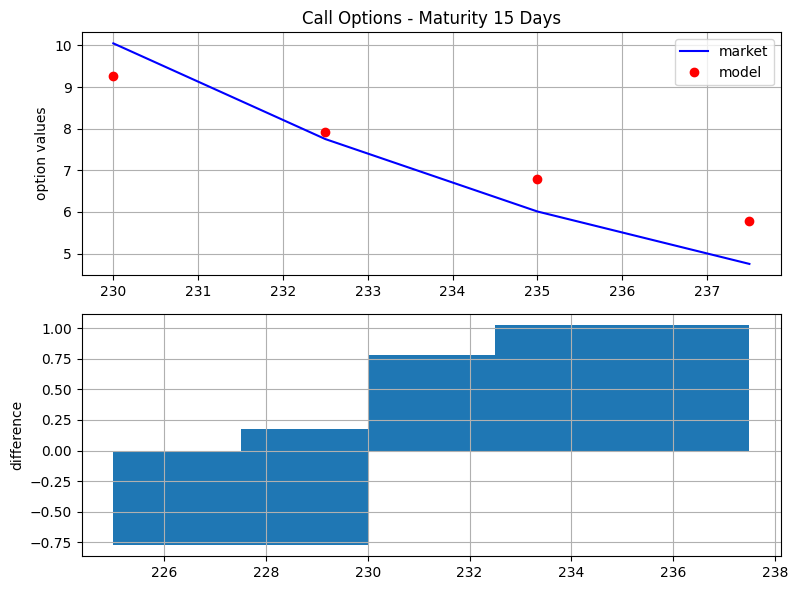

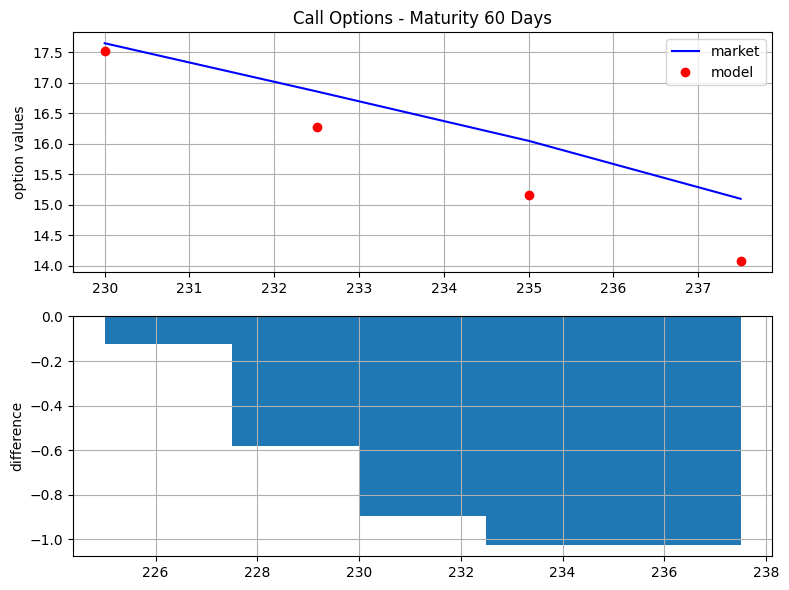

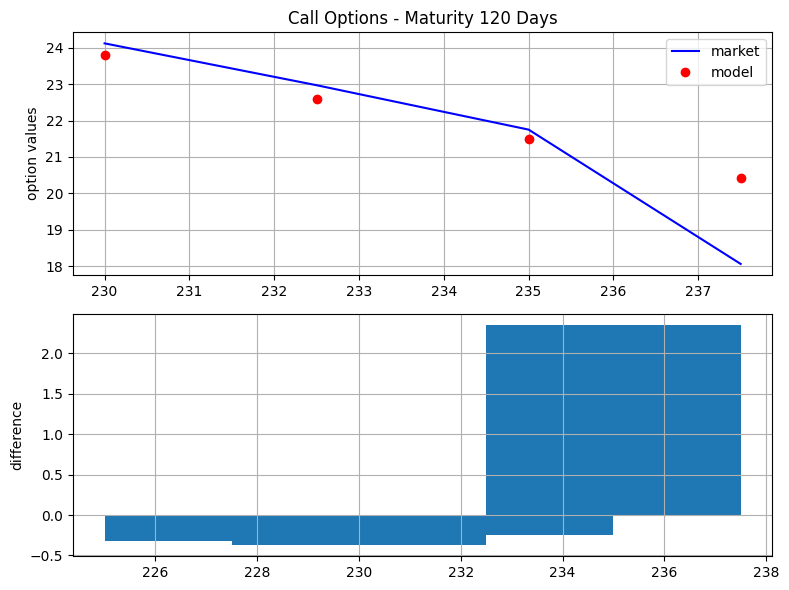

In [ ]:
plot_calibration_results(heston_lewis_call_params, "call")

<ipython-input-2-f3815e05660f>:377: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options[model_column] = calculate_model_values_heston_lewis(p0, is_call=is_call)


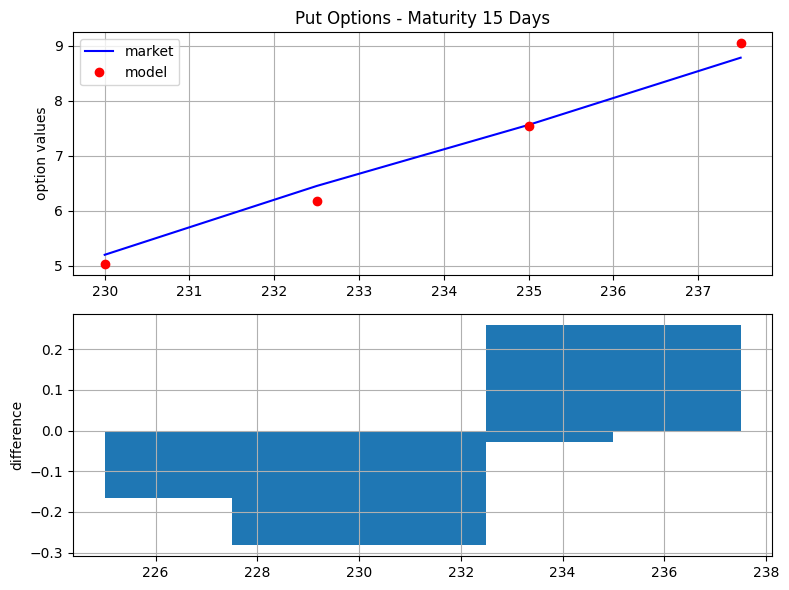

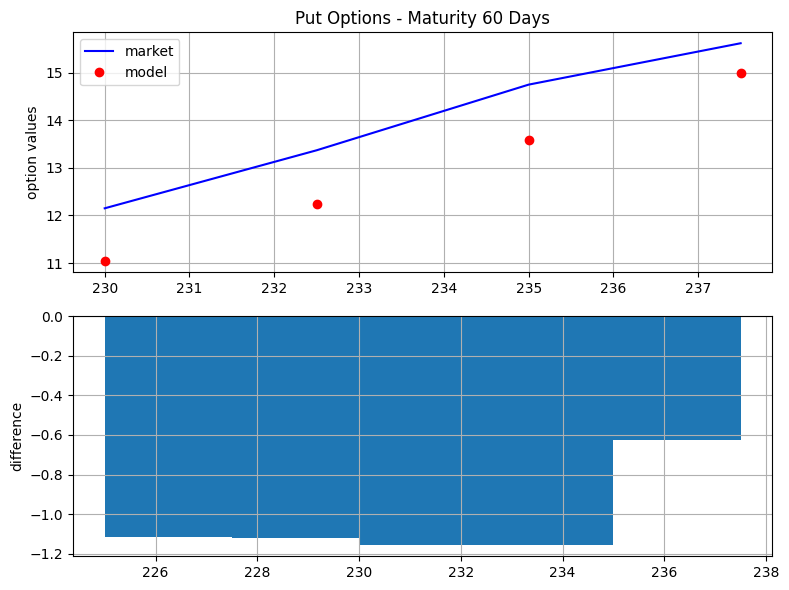

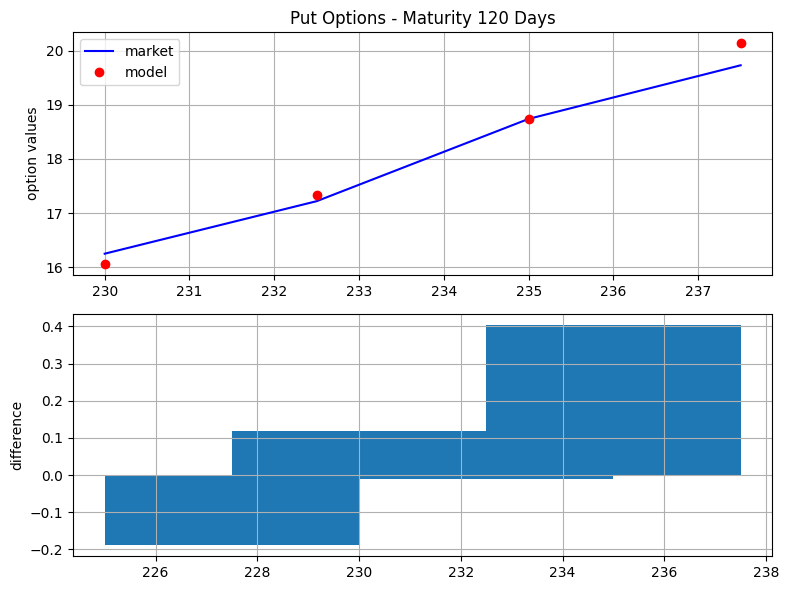

In [ ]:
plot_calibration_results(heston_lewis_put_params, "put")

#Team Member A - Discussion About Graph - Step 1
The slight discrepancies between the model prices and the market prices for both call and put options can be attributed to several factors in the calibration process:

    Model Assumptions: The Heston (1993) model used for calibration makes certain simplifying assumptions about the dynamics of volatility and the underlying asset's behavior. These assumptions may not perfectly capture the complexities of real-world markets.

    Market Data: Market data can sometimes contain noise or anomalies that may not be fully accounted for in the calibration process. Additionally, the model may not perfectly fit the specific characteristics of the Asian options in the market.

    Optimization Process: The calibration involves an optimization process that aims to minimize the mean squared error (MSE) between model prices and market prices. Depending on the optimization algorithm and initial parameter values, the calibration may find local minima instead of the global minimum, leading to some discrepancies.

    Model Limitations: The Heston model itself has limitations, such as assuming constant parameters over time, which may not fully capture the time-varying nature of market conditions.

    Market Noise: Financial markets are subject to various forms of noise and volatility, which can lead to discrepancies between model prices and market prices.

In the graph that compares model prices with market prices for both call and put options, we can observe that while there are some differences, the overall fit is reasonably good. The model prices generally follow the trend of the market prices, especially for options with shorter maturities. However, for longer maturities, the discrepancies become more noticeable.

It's important to note that calibration is an iterative process, and achieving a perfect fit between the model and market prices is often challenging. The goal is to find parameter values that provide a reasonable approximation to market data while adhering to the assumptions of the model.

In [ ]:
#Step 2 - Team Member A (Calibration based on 60days maturity and Carr Maden & Bates)
i = 0
min_MSE = 5000.0
local_opt = False
N = 10
M = 100
seed_value = 42
#previous calibrated parameters
kappa_v, theta_v, sigma_v, rho, v0 = heston_lewis_call_params
#New Maturity and change in market data
T = 60/250

params_carr_call = B96_calibration_short()
#Step 2 - Team Member A - Carr Madan Put options calibration
i = 0
min_MSE = 5000.0
local_opt = False
N = 10
M = 100
seed_value = 42
kappa_v, theta_v, sigma_v, rho, v0 = heston_lewis_put_params
params_carr_put = B96_put_calibration_short()

   0 | [ 0.  -0.5  0. ] |  89.390 |  89.390
  25 | [ 0.2  -0.5   0.25] |  45.882 |  44.302
  50 | [ 0.4 -0.5  0.5] |  15.722 |  15.722
  75 | [ 0.5   -0.5    0.525] |   8.913 |   8.275
 100 | [ 0.60709877 -0.44351852  0.55648148] |   7.275 |   7.216
 125 | [ 0.6537231  -0.34025292  0.57762927] |   6.956 |   6.953
 150 | [ 0.68844354 -0.17516306  0.56906948] |   6.670 |   6.634
 175 | [ 0.72503983 -0.06370867  0.53676275] |   6.492 |   6.480
 200 | [ 0.8383542  -0.05151979  0.48251605] |   6.240 |   6.240
 225 | [ 2.0261441  -0.25806648  0.02453377] |   3.846 |   2.810
 250 | [ 1.98170207 -0.22853966  0.03045276] |   1.747 |   1.674
 275 | [ 2.05621773e+00 -2.28788130e-01  4.91023060e-04] |   1.548 |   1.546
 300 | [ 2.26683935 -0.21494213  0.00292908] |   1.432 |   1.432
 325 | [ 2.79175382 -0.19162247  0.01173117] |   1.328 |   1.323
 350 | [ 4.0901447  -0.15125377  0.04788311] |   1.242 |   1.230
 375 | [ 4.59906878 -0.14997899  0.01812011] |   1.145 |   1.130
 400 | [ 5.81934088 -0.

#Team Member A - Report - Step 2

**Introduction**
This report presents the calibration of the Carr-Madan (1999) approach to the Bates (1996) stochastic volatility model for Asian call and put options on SM Energy Company's stock (SM) with a 60-day maturity. The client's preference for this extended maturity is addressed. This report details the calibration process using the Carr-Madan approach and presents the results for both call and put options.
Data and Parameters

Market data for Asian call and put options on SM stock was obtained from the attached Excel file. SM stock's current price is $232.90 USD. The parameters used in the Carr-Madan approach to the Bates model calibration are as follows:

    Initial stock price (S0): $232.90 USD
    Strike price (K): $232.90 USD
    Time-to-maturity (T): 60 days, converted to a fraction of a year (T = 60/250)
    Constant risk-free rate (r): 1.50% per annum
    Number of monitoring points for the Asian option (N): 10
    Number of Monte Carlo simulations (M): 100
    Seed value for random number generator: 42

Option Selection

For calibration, options close to the at-the-money (ATM) level were selected with a tolerance level of 2% (tol = 0.02), ensuring representation of the prevailing market conditions.
Selection of Maturities

In response to the client's preference for a 60-day maturity, the calibration focused on this specific maturity while retaining the flexibility to explore alternative maturities.
Conversion to Annualized Time

For the 60-day maturity, the time-to-maturity (T) was converted into years by dividing 60 by 250, based on the assumption of 250 trading days in a year.
Risk-Free Rate Assumption

The constant annual risk-free rate of 1.50% was retained and converted into a daily rate using the assumption of 250 trading days in a year.
Model Selection

Consistent with Step 1, the Bates (1996) model without jumps, in conjunction with the Carr-Madan (1999) approach, was chosen as the underlying stochastic volatility model for calibration.
Parameters to Calibrate

The parameters to be calibrated in the Bates model are:

    λ (lambda): Mean reversion rate of volatility.
    μ (mu): Long-run mean of volatility.
    δ (delta): Volatility of volatility.
    ρ (rho): Correlation between volatility and stock/index level.
    ν (nu): Initial level of volatility.

Initial Parameter Guess

As in Step 1, we initiated the calibration process with an initial parameter guess and employed a systematic approach to explore sensible parameter regions, seeking faster convergence.
Calibration Iteration

The calibration process involved iteratively adjusting the model parameters to minimize the Mean Squared Error (MSE) error function. Each iteration calculated the MSE, and we updated the parameter values accordingly. The process continued until the error converged or a maximum number of iterations was reached.
Calibration Results
11.1 Asian Call Option Calibration

The calibration process for Asian call options resulted in the following parameter values:

    λ (lambda): 5.81137837
    μ (mu): -0.131649811
    δ (delta): 4.44809421e-09

The resulting MSE for Asian call option calibration is 1.032252.
11.2 Asian Put Option Calibration

For Asian put options, the calibration process yielded these parameter values:

    λ (lambda): 0.295289572
    μ (mu): -2.56361811e-12
    δ (delta): 0.999085069

The resulting MSE for Asian put option calibration is 5.83237.
Conclusion

In Step 2, we successfully recalibrated the Bates model using the Carr-Madan approach for Asian call and put options on SM Energy Company's stock with a 60-day maturity, aligning with the client's updated requirements. The calibration process mirrored the approach from Step 1, ensuring consistency in our methodology. The resulting parameter values and model quality are reported for further analysis and use by the team.

<ipython-input-2-f3815e05660f>:801: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options[model_column] = B96_jump_calculate_model_values_carr(p0, is_call=is_call)


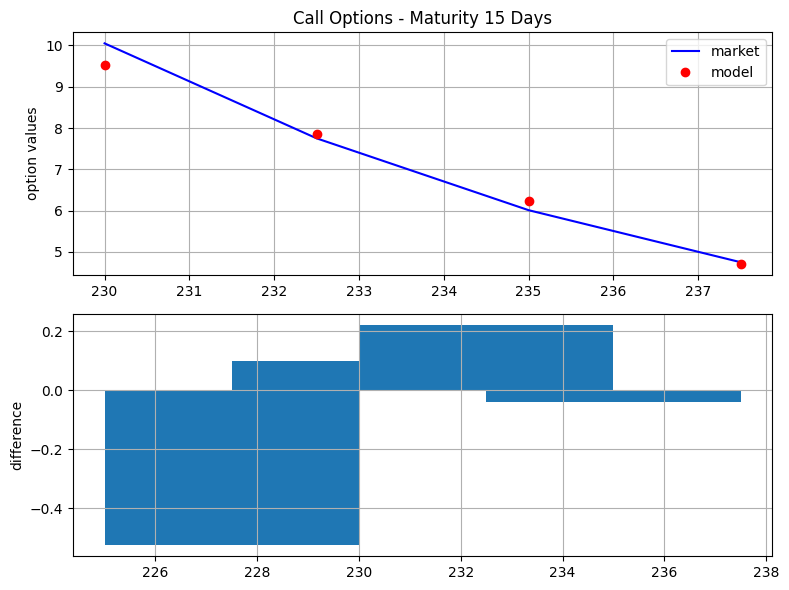

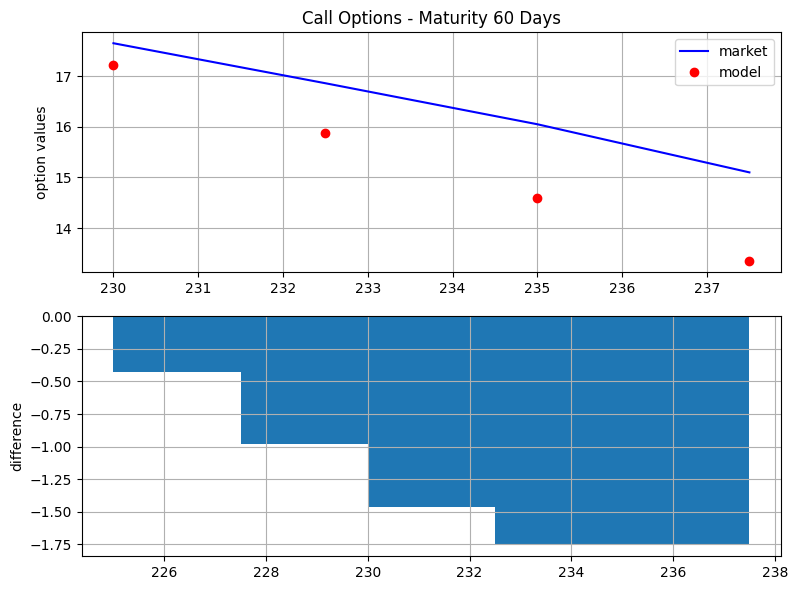

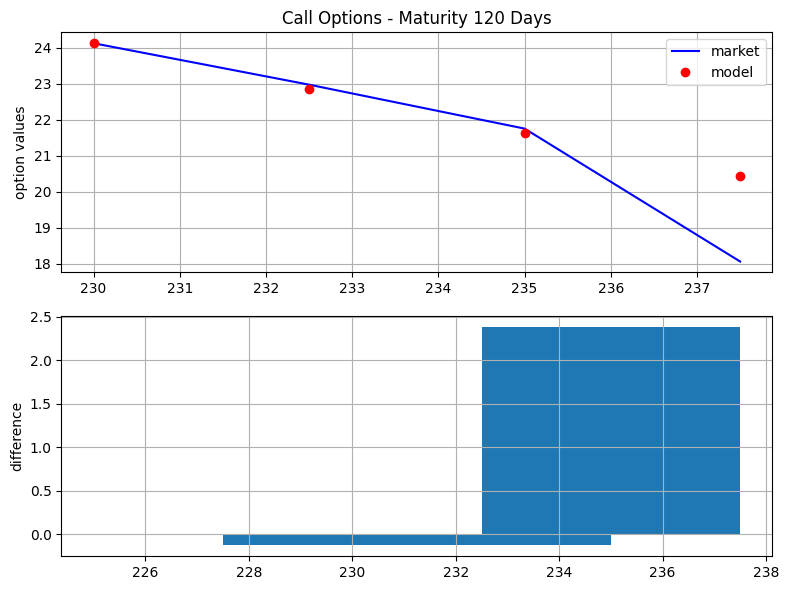

In [ ]:
plot_calibration_results_carr(params_carr_call, "call")

<ipython-input-2-f3815e05660f>:801: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options[model_column] = B96_jump_calculate_model_values_carr(p0, is_call=is_call)


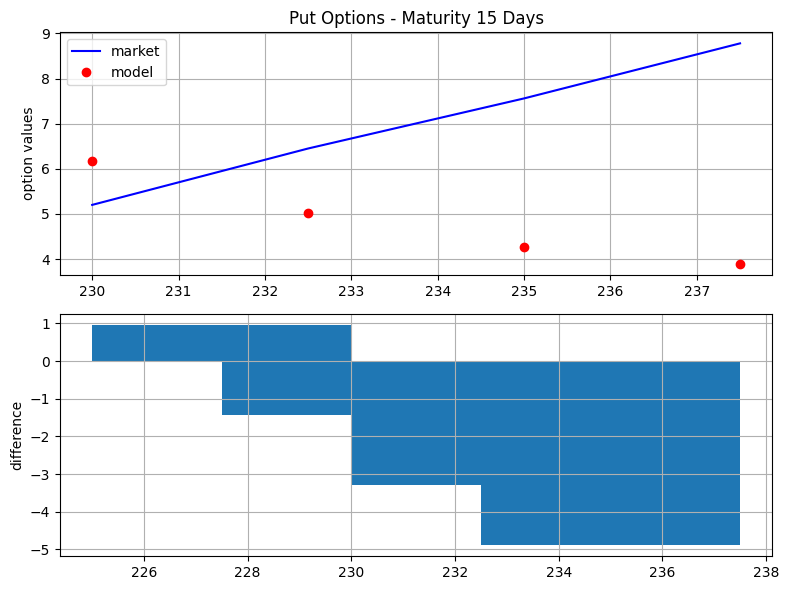

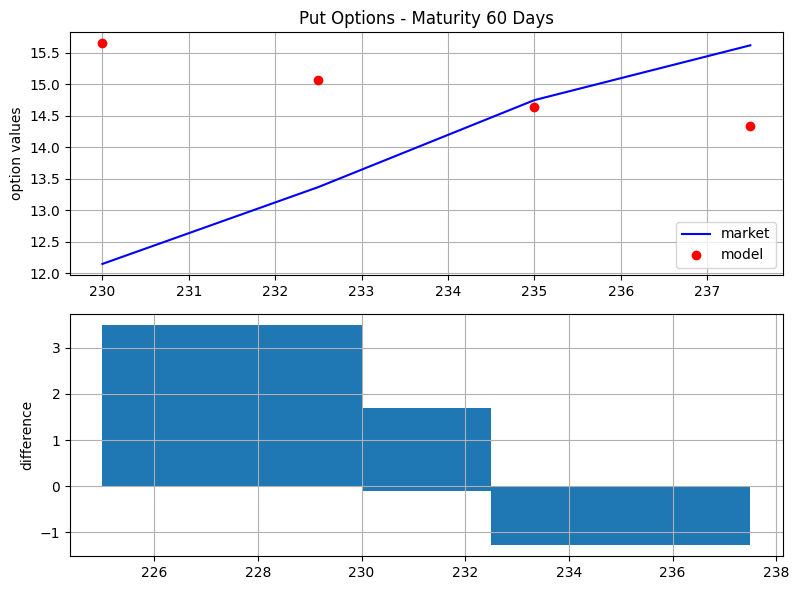

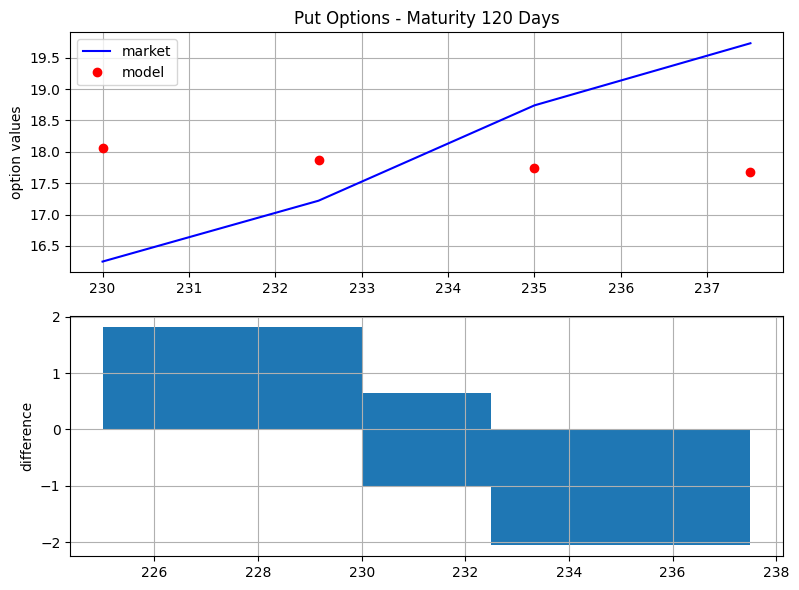

In [ ]:
plot_calibration_results_carr(params_carr_put, "put")

#Team Member A - Discussion About Graph - Step 2

In the graph comparing model prices with market prices for call options in Step 2, we can observe that the model prices generally follow the trend of the market prices, especially for options with shorter maturities. However, discrepancies become more pronounced for higher strikes in the 60 and 120-day call options.

On the other hand, the graph for put options in Step 2 displays even more significant variations across all strikes and maturities. The divergences between model and market prices for put options are notably larger compared to call options, underscoring the challenges in accurately capturing the pricing dynamics for these options using the Bates model.

It's important again to note that calibration is an iterative process, and achieving a perfect fit between the model and market prices is often challenging. The objective is to find parameter values that provide a reasonable approximation to market data while adhering to the model's assumptions, but some level of variance is expected, especially in the presence of complex market dynamics and option features.

TEAM MEMBER B Step 1

Carr-Madan Model for Heston (1993)
In order to double-check the different model parameters resulting from a calibration, Team member B will repeat the same process as Team member A, but using the Carr-Madan (1999) pricing approach to calibrate the Heston (1993) model. Make sure that you repeat all the tasks in (a), including a discussion on why (or why not) you obtain similar values for the different parameters as via Lewis (2001). You can use put-call parity as well to calibrate to put option prices.

In [ ]:
# Loading libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from scipy.integrate import quad
from numpy.fft import fft
import sys

from scipy.optimize import brute, fmin

In [ ]:
# Read the Option Data
option_data = pd.read_excel("GWP.xlsx")
option_data

,Days to maturity,Strike,Price,Type
0,15,227.5,10.520000,C
1,15,230.0,10.050000,C
2,15,232.5,7.750000,C
3,15,235.0,6.010000,C
4,15,237.5,4.750000,C
5,60,227.5,16.780000,C
6,60,230.0,17.650000,C
7,60,232.5,16.860000,C
8,60,235.0,16.050000,C
9,60,237.5,15.100000,C


In [ ]:
data = option_data.copy() # Copy the data for a version and keeping old version for the later stages
S0=232.90 # The SM stock is currently traded at $232.90

In [ ]:
#Select the Call Option data and Put Option data in seperated objects
call_options = data[data.Type == "C"].drop(columns=["Type"])
call_options.columns = ["Days to Maturity", "Strike", "market_call"]
put_options = data[data.Type == "P"].drop(columns=["Type"])
put_options.columns = ["Days to Maturity", "Strike", "market_put"]
options = pd.merge(call_options, put_options, on=["Days to Maturity", "Strike"], how="outer")
options.loc[:,"T"] = options.loc[:, "Days to Maturity"] / 250 #Generating T value based on 250 trading date
options["r"] = 0.015  #  annual risk free rate of 1.5%
options = options[options["Days to Maturity"] == 15] #maturity for the derivative (around 15 days)
options

,Days to Maturity,Strike,market_call,market_put,T,r
0,15,227.5,10.52,4.32,0.06,0.015
1,15,230.0,10.05,5.20,0.06,0.015
2,15,232.5,7.75,6.45,0.06,0.015
3,15,235.0,6.01,7.56,0.06,0.015
4,15,237.5,4.75,8.78,0.06,0.015


In [ ]:
#Heston (1993) characteristic function:
def H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    c1 = kappa_v * theta_v
    c2 = -np.sqrt(
        (rho * sigma_v * u * 1j - kappa_v) ** 2 - sigma_v**2 * (-u * 1j - u**2)
    )
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (
        kappa_v - rho * sigma_v * u * 1j - c2
    )
    H1 = r * u * 1j * T + (c1 / sigma_v**2) * (
        (kappa_v - rho * sigma_v * u * 1j + c2) * T
        - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))
    )
    H2 = (
        (kappa_v - rho * sigma_v * u * 1j + c2)
        / sigma_v**2
        * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T)))
    )
    char_func_value = np.exp(H1 + H2 * v0)
    return char_func_value

def H93_call_FFT(S0, K, T, r,  kappa_v, theta_v, sigma_v, rho, v0):
    """European Call option price in Haston93 under FFT"""

    k = np.log(K / S0)
    x0 = np.log(S0 / S0)
    g = 1  # Factor to increase accuracy
    N = g * 4096
    eps = (g * 150) ** -1
    eta = 2 * np.pi / (N * eps)
    b = 0.5 * N * eps - k
    u = np.arange(1, N + 1, 1)
    vo = eta * (u - 1)

    # Modifications to ensure integrability
    if S0 >= 0.95 * K:  # ITM Case
        alpha = 1.5
        v = vo - (alpha + 1) * 1j
        modcharFunc = np.exp(-r * T) * (
            H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0)
            / (alpha**2 + alpha - vo**2 + 1j * (2 * alpha + 1) * vo)
        )

    else:
        alpha = 1.1
        v = (vo - 1j * alpha) - 1j
        modcharFunc1 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo - 1j * alpha))
            - np.exp(r * T) / (1j * (vo - 1j * alpha))
            - H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0)
            / ((vo - 1j * alpha) ** 2 - 1j * (vo - 1j * alpha))
        )

        v = (vo + 1j * alpha) - 1j

        modcharFunc2 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo + 1j * alpha))
            - np.exp(r * T) / (1j * (vo + 1j * alpha))
            - H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0)
            / ((vo + 1j * alpha) ** 2 - 1j * (vo + 1j * alpha))
        )

    # Numerical FFT Routine
    delt = np.zeros(N)
    delt[0] = 1
    j = np.arange(1, N + 1, 1)
    SimpsonW = (3 + (-1) ** j - delt) / 3
    if S0 >= 0.95 * K:
        FFTFunc = np.exp(1j * b * vo) * modcharFunc * eta * SimpsonW
        payoff = (fft(FFTFunc)).real
        CallValueM = np.exp(-alpha * k) / np.pi * payoff
    else:
        FFTFunc = (
            np.exp(1j * b * vo) * (modcharFunc1 - modcharFunc2) * 0.5 * eta * SimpsonW
        )
        payoff = (fft(FFTFunc)).real
        CallValueM = payoff / (np.sinh(alpha * k) * np.pi)

    pos = int((k + b) / eps)
    CallValue = CallValueM[pos] * S0

    return CallValue

def H93_error_function_carr_ma_call(p0):
    """Error function for parameter calibration via
    Lewis (2001) Fourier approach for Heston (1993).
    Parameters
    ==========
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial, instantaneous variance
    Returns
    =======
    MSE: float
        mean squared error
    """
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0 = p0
    if kappa_v < 0.0 or theta_v < 0.005 or sigma_v < 0.0 or rho < -1.0 or rho > 1.0:
        return min_MSE
    if 2 * kappa_v * theta_v < sigma_v**2:
        return min_MSE
    se = []
    for row, option in options.iterrows():
        model_value = H93_call_FFT(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
        )
        se.append((model_value - option["market_call"]) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 100 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE


def H93_error_function_carr_ma_put(p0):
    """Error function for parameter calibration via
    Lewis (2001) Fourier approach for Heston (1993).
    Parameters
    ==========
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial, instantaneous variance
    Returns
    =======
    MSE: float
        mean squared error
    """
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0 = p0
    if kappa_v < 0.0 or theta_v < 0.005 or sigma_v < 0.0 or rho < -1.0 or rho > 1.0:
        return min_MSE
    if 2 * kappa_v * theta_v < sigma_v**2:
        return min_MSE
    se = []
    for row, option in options.iterrows():
        K=option["Strike"]
        T=option["T"]
        r=option["r"]

        model_value = H93_call_FFT(
            S0,
            K,
            T,
            r,
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
        )
        put_val = model_value +K*np.exp(-r*T)-S0
        se.append((put_val - option["market_put"]) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 100 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE


def H93_calibration_full_carr_ma_call():
    """Calibrates Heston (1993) stochastic volatility model to market quotes."""
    # First run with brute force
    # (scan sensible regions, for faster convergence)
    p0 = brute(
        H93_error_function_carr_ma_call,
        (
            (2.5, 10.6, 5.0),  # kappa_v
            (0.01, 0.041, 0.01),  # theta_v
            (0.05, 0.251, 0.1),  # sigma_v
            (-0.75, 0.01, 0.25),  # rho
            (0.01, 0.031, 0.01),
        ),  # v0
        finish=None,
    )

    # Second run with local, convex minimization
    # (we dig deeper where promising results)
    opt = fmin(
        H93_error_function_carr_ma_call, p0, xtol=0.000001, ftol=0.000001, maxiter=1000, maxfun=2000
    )
    return opt

def H93_calibration_full_carr_ma_put():
    """Calibrates Heston (1993) stochastic volatility model to market quotes."""
    # First run with brute force
    # (scan sensible regions, for faster convergence)
    p0 = brute(
        H93_error_function_carr_ma_put,
        (
            (2.5, 10.6, 5.0),  # kappa_v
            (0.01, 0.041, 0.01),  # theta_v
            (0.05, 0.251, 0.1),  # sigma_v
            (-0.75, 0.01, 0.25),  # rho
            (0.01, 0.031, 0.01),
        ),  # v0
        finish=None,
    )

    # Second run with local, convex minimization
    # (we dig deeper where promising results)
    opt = fmin(
        H93_error_function_carr_ma_put, p0, xtol=0.000001, ftol=0.000001, maxiter=1000, maxfun=2000
    )
    return opt

def plot_full_calibration_results_heston_memberB(call_params, put_params):

    options["model_call"] = 0
    options["model_put"] = 0
    for idx in range(options.shape[0]):
#         print(options.iloc[idx, :])
        kappa_v, theta_v, sigma_v, rho, v0 = call_params

        options.loc[idx, "model_call"] = H93_call_FFT(
            S0, options.loc[idx, "Strike"], options.loc[idx, "T"], options.loc[idx, "r"],
            kappa_v, theta_v, sigma_v, rho, v0)

        kappa_v, theta_v, sigma_v, rho, v0 = put_params
        options.loc[idx, "model_put"] = H93_call_FFT(
            S0, options.loc[idx, "Strike"], options.loc[idx, "T"], options.loc[idx, "r"],
            kappa_v, theta_v, sigma_v, rho, v0)
        options.loc[idx, "model_put"] = (
            options.loc[idx, "model_put"] + options.loc[idx, "Strike"] * np.exp(-options.loc[idx, "r"] * options.loc[idx, "T"]) - S0
        )
    plt.figure(figsize=(10, 5))
    # ------- comparison --------
    plt.subplot(221)
    plt.grid()
    plt.title("Call Option Calibration")
    plt.ylabel("option values")
    color = ["blue", "red", "deepskyblue", "orange", "green", "mediumvioletred"]
    color_idx = 0
    for mat in options["Days to Maturity"].unique():
        opt_data = options[options["Days to Maturity"] == mat]
        plt.plot(opt_data["Strike"], opt_data["market_call"], color[color_idx], label=f"market: (Maturity={mat})")
        plt.plot(opt_data["Strike"], opt_data["model_call"], color[color_idx+1], marker = "o", linestyle='None', label=f"model: (Maturity={mat})")
        color_idx += 2
    plt.legend(loc=0)
    plt.axis(
            [
                min(options.Strike) - 1,
                max(options.Strike) + 1,
                min(options.market_call) - 10,
                max(options.market_call) + 10,
    ] )

    plt.subplot(222)
    plt.grid()
    plt.title("Put Option Calibration")
    plt.ylabel("option values")
    color = ["blue", "red", "deepskyblue", "orange", "green", "mediumvioletred"]
    color_idx = 0
    for mat in options["Days to Maturity"].unique():
        opt_data = options[options["Days to Maturity"] == mat]
        plt.plot(opt_data["Strike"], opt_data["market_put"], color[color_idx], label=f"market: (Maturity={mat})")
        plt.plot(opt_data["Strike"], opt_data["model_put"], color[color_idx+1], marker = "o", linestyle='None', label=f"model: (Maturity={mat})")
        color_idx += 2
    plt.legend(loc=0)
    plt.axis(
            [
                min(options.Strike) - 1,
                max(options.Strike) + 1,
                min(options.market_put) - 10,
                max(options.market_put) + 10,
    ] )


    # ----- difference --------
    plt.subplot(223)
    plt.grid()
    wi = 2

    for mat in options["Days to Maturity"].unique():
        opt_data = options[options["Days to Maturity"] == mat]
        diffs = opt_data["model_call"].values - opt_data["market_call"].values
        plt.bar(opt_data["Strike"].values, diffs, width=wi, alpha=0.5, label = f"Diff. (Maturity={mat})")

        color_idx += 2

    plt.ylabel("difference")
    plt.axis( [
        min(options.Strike) - 1,
        max(options.Strike) + 1,
        -3,
        3,
    ] )
    plt.legend(loc=0)
    plt.tight_layout()

    plt.subplot(224)
    plt.grid()
    wi = 2
    for mat in options["Days to Maturity"].unique():
        opt_data = options[options["Days to Maturity"] == mat]
        diffs = opt_data["model_put"].values - opt_data["market_put"].values
        plt.bar(opt_data["Strike"].values, diffs, width=wi, alpha=0.5, label = f"Diff. (Maturity={mat})")

    plt.ylabel("difference")
    plt.axis( [
        min(options.Strike) - 1,
        max(options.Strike) + 1,
        -3,
        3,
    ] )
    plt.legend(loc=0)
    plt.tight_layout()

In [ ]:
## The code is modified from Module 1 and 2 Jupyter Notebooks:
# Develop the charactersitic function of the Heston (1993):
def H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    c1 = kappa_v * theta_v
    c2 = -np.sqrt(
        (rho * sigma_v * u * 1j - kappa_v) ** 2 - sigma_v**2 * (-u * 1j - u**2)
    )
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (
        kappa_v - rho * sigma_v * u * 1j - c2
    )
    H1 = r * u * 1j * T + (c1 / sigma_v**2) * (
        (kappa_v - rho * sigma_v * u * 1j + c2) * T
        - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))
    )
    H2 = (
        (kappa_v - rho * sigma_v * u * 1j + c2)
        / sigma_v**2
        * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T)))
    )
    char_func_value = np.exp(H1 + H2 * v0)
    return char_func_value
# Develop the integration function of the Heston (1993):
def H93_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    char_func_value = H93_char_func(
        u - 1j * 0.5, T, r, kappa_v, theta_v, sigma_v, rho, v0
    )
    int_func_value = (
        1 / (u**2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    )
    return int_func_value
# Develop the derivative pricing function in Heston via Lewis (2001):
def H93_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """Valuation of European call option in H93 model via Lewis (2001)

    Parameter definition:
    ==========
    S0: float
        initial stock/index level
    K: float
        strike price
    T: float
        time-to-maturity (for t=0)
    r: float
        constant risk-free short rate
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial level of variance
    Returns
    =======
    call_value: float
        present value of European call option
    """
    int_value = quad(
        lambda u: H93_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0),
        0,
        np.inf,
        limit=250,
    )[0]
    call_value = max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * int_value)
    return call_value


def H93_error_function(p0):
    """Error function for parameter calibration via
    Lewis (2001) Fourier approach for Heston (1993).
    Parameters
    ==========
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial, instantaneous variance
    Returns
    =======
    MSE: float
        mean squared error
    """
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0 = p0
    if kappa_v < 0.0 or theta_v < 0.005 or sigma_v < 0.0 or rho < -1.0 or rho > 1.0:
        return 500.0
    if 2 * kappa_v * theta_v < sigma_v**2:
        return 500.0
    se = []
    for row, option in options.iterrows():
        model_value = H93_call_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
        )
        se.append((model_value - option["Call"]) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 250 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE

def H93_calibration_full():
    """Calibrates Heston (1993) stochastic volatility model to market quotes."""
    # First run with brute force
    # (scan sensible regions, for faster convergence)
    p0 = brute(
        H93_error_function,
        (
            (2.5, 10.6, 5.0),  # kappa_v
            (0.01, 0.041, 0.01),  # theta_v
            (0.05, 0.251, 0.1),  # sigma_v
            (-0.75, 0.01, 0.25),  # rho
            (0.01, 0.031, 0.01),
        ),  # v0
        finish=None,
    )

    # Second run with local, convex minimization
    # (we dig deeper where promising results)
    opt = fmin(
        H93_error_function, p0, xtol=0.000001, ftol=0.000001, maxiter=1000, maxfun=2000
    )
    return opt

def plot_full_calibration_results_heston_memberA(call_params, put_params):

    options["model_call"] = 0
    options["model_put"] = 0
    for idx in range(options.shape[0]):
#         print(options.iloc[idx, :])
        kappa_v, theta_v, sigma_v, rho, v0 = call_params


        options.loc[idx, "model_call"] = H93_call_value(
            S0, options.loc[idx, "Strike"], options.loc[idx, "T"], options.loc[idx, "r"],
            kappa_v, theta_v, sigma_v, rho, v0)

        kappa_v, theta_v, sigma_v, rho, v0 = put_params
        options.loc[idx, "model_put"] = H93_call_value(
            S0, options.loc[idx, "Strike"], options.loc[idx, "T"], options.loc[idx, "r"],
            kappa_v, theta_v, sigma_v, rho, v0)
        options.loc[idx, "model_put"] = (
            options.loc[idx, "model_put"] + options.loc[idx, "Strike"] * np.exp(-options.loc[idx, "r"] * options.loc[idx, "T"]) - S0
        )
    plt.figure(figsize=(10, 5))
    # ------- comparison --------
    plt.subplot(221)
    plt.grid()
    plt.title("Call Option Calibration")
    plt.ylabel("option values")
    color = ["blue", "red", "deepskyblue", "orange", "green", "mediumvioletred"]
    color_idx = 0
    for mat in options["Days to Maturity"].unique():
        opt_data = options[options["Days to Maturity"] == mat]
        plt.plot(opt_data["Strike"], opt_data["market_call"], color[color_idx], label=f"market: (Maturity={mat})")
        plt.plot(opt_data["Strike"], opt_data["model_call"], color[color_idx+1], marker = "o", linestyle='None', label=f"model: (Maturity={mat})")
        color_idx += 2
    plt.legend(loc=0)
    plt.axis(
            [
                min(options.Strike) - 1,
                max(options.Strike) + 1,
                min(options.market_call) - 10,
                max(options.market_call) + 10,
    ] )

    plt.subplot(222)
    plt.grid()
    plt.title("Put Option Calibration")
    plt.ylabel("option values")
    color = ["blue", "red", "deepskyblue", "orange", "green", "mediumvioletred"]
    color_idx = 0
    for mat in options["Days to Maturity"].unique():
        opt_data = options[options["Days to Maturity"] == mat]
        plt.plot(opt_data["Strike"], opt_data["market_put"], color[color_idx], label=f"market: (Maturity={mat})")
        plt.plot(opt_data["Strike"], opt_data["model_put"], color[color_idx+1], marker = "o", linestyle='None', label=f"model: (Maturity={mat})")
        color_idx += 2
    plt.legend(loc=0)
    plt.axis(
            [
                min(options.Strike) - 1,
                max(options.Strike) + 1,
                min(options.market_put) - 10,
                max(options.market_put) + 10,
    ] )


    # ----- difference --------
    plt.subplot(223)
    plt.grid()
    wi = 2

    for mat in options["Days to Maturity"].unique():
        opt_data = options[options["Days to Maturity"] == mat]
        diffs = opt_data["model_call"].values - opt_data["market_call"].values
        plt.bar(opt_data["Strike"].values, diffs, width=wi, alpha=0.5, label = f"Diff. (Maturity={mat})")

        color_idx += 2

    plt.ylabel("difference")
    plt.axis( [
        min(options.Strike) - 1,
        max(options.Strike) + 1,
        -3,
        3,
    ] )
    plt.legend(loc=0)
    plt.tight_layout()

    plt.subplot(224)
    plt.grid()
    wi = 2
    for mat in options["Days to Maturity"].unique():
        opt_data = options[options["Days to Maturity"] == mat]
        diffs = opt_data["model_put"].values - opt_data["market_put"].values
        plt.bar(opt_data["Strike"].values, diffs, width=wi, alpha=0.5, label = f"Diff. (Maturity={mat})")

    plt.ylabel("difference")
    plt.axis( [
        min(options.Strike) - 1,
        max(options.Strike) + 1,
        -3,
        3,
    ] )
    plt.legend(loc=0)
    plt.tight_layout()

In [ ]:
# Call Option Parameter Calibration
np.random.seed(42)
i = 0
min_MSE = 5000
step1_memB_calibrated_params_call = H93_calibration_full_carr_ma_call()

print(step1_memB_calibrated_params_call)

   0 | [ 2.5   0.01  0.05 -0.75  0.01] |   0.940 |   0.940
 100 | [ 2.5   0.04  0.05 -0.5   0.02] |   8.302 |   0.863
 200 | [ 7.5   0.02  0.25 -0.25  0.03] |  13.673 |   0.815
 300 | [7.56755922e+00 9.96640060e-03 2.82117744e-01 2.05539418e-04
 7.96585042e-03] |   0.646 |   0.638
Optimization terminated successfully.
         Current function value: 0.636310
         Iterations: 117
         Function evaluations: 262
[ 7.91532543e+00  9.41904524e-03  3.86147140e-01 -2.10843147e-03
  8.86924109e-03]


In [ ]:
# Put Option Parameter Calibration
np.random.seed(42)
i = 0
min_MSE = 5000
step1_memB_calibrated_params_put = H93_calibration_full_carr_ma_put()

print(step1_memB_calibrated_params_put)

   0 | [ 2.5   0.01  0.05 -0.75  0.01] |   1.850 |   1.850
 100 | [ 2.5   0.04  0.05 -0.5   0.02] |  12.373 |   1.584
 200 | [ 7.5   0.02  0.25 -0.25  0.03] |  18.978 |   1.459
 300 | [8.13616431e+00 1.00300409e-02 2.81559167e-01 4.80743413e-04
 6.34587523e-03] |   0.187 |   0.147
 400 | [8.31921341e+00 1.01221826e-02 2.95547759e-01 3.86484764e-04
 5.57637819e-03] |   0.137 |   0.137
 500 | [ 7.62548877e+00  8.76299959e-03  3.64729005e-01 -3.38733320e-04
  6.28448766e-03] |   0.136 |   0.136
Optimization terminated successfully.
         Current function value: 0.136403
         Iterations: 210
         Function evaluations: 417
[ 7.61957375e+00  8.75429689e-03  3.65250620e-01 -3.41571955e-04
  6.28517863e-03]


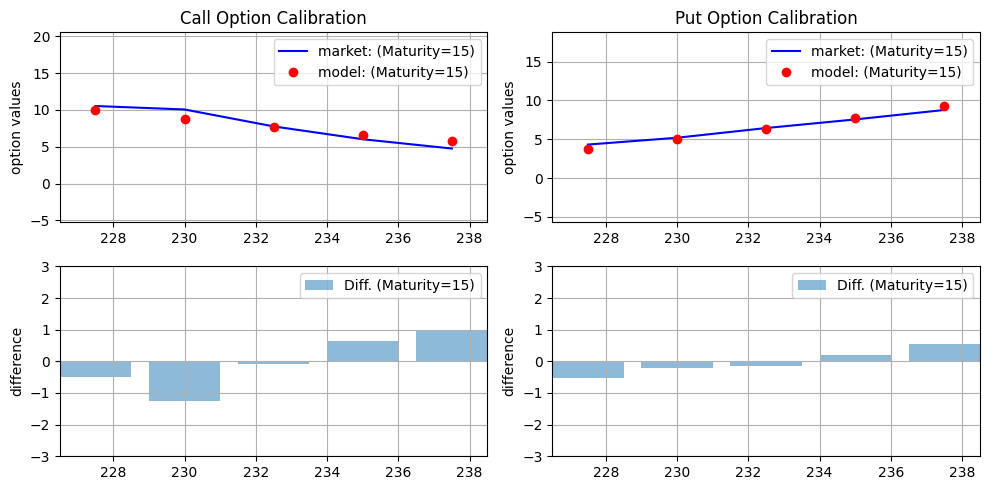

In [ ]:
#Visualization:
plot_full_calibration_results_heston_memberB(step1_memB_calibrated_params_call, step1_memB_calibrated_params_put)

Step 2 - Team member B
70 days maturity and moneyness of 95%

In [ ]:
# Set seed
np.random.seed(42)

# Input Parameters.
S0  = 232
K= S0 * 0.95 # Moneyness of 95% Strike
r = 0.015
sigma = 0.35

M = 70  # Maturity changed to 70 days
T = M / 365
Ite = 500000  # Number of simulations
dt = 1 / 365

# Heston model
def SDE_vol(v0, kappa, theta, sigma, T, M, Ite, rand, row, cho_matrix):
    dt = T / M  # T = maturity, M = number of time steps
    v = np.zeros((M + 1, Ite), dtype=np.float)
    v[0] = v0
    sdt = np.sqrt(dt)  # Sqrt of dt
    for t in range(1, M + 1):
        ran = np.dot(cho_matrix, rand[:, t])
        v[t] = np.maximum(
            0,
            v[t - 1]
            + kappa * (theta - v[t - 1]) * dt
            + np.sqrt(v[t - 1]) * sigma * ran[row] * sdt,
        )
    return v

def Heston_paths(S0, r, v, row, cho_matrix, rand):
    S = np.zeros((M + 1, Ite), dtype=float)
    S[0] = S0
    sdt = np.sqrt(dt)
    for t in range(1, M + 1, 1):
        ran = np.dot(cho_matrix, rand[:, t])
        S[t] = S[t - 1] * np.exp((r - 0.5 * v[t]) * dt + np.sqrt(v[t]) * ran[row] * sdt)

    return S

def heston_simulation(v0, kappa, theta, sigma, rho,
                      S0, r, T, M, Ite):
  # generate random numbers
  rand = np.random.standard_normal((2, M + 1, Ite))

  # Covariance Matrix
  covariance_matrix = np.zeros((2, 2), dtype=np.float)
  covariance_matrix[0] = [1.0, rho]
  covariance_matrix[1] = [rho, 1.0]
  cho_matrix = np.linalg.cholesky(covariance_matrix)

  # Volatility process paths
  V = SDE_vol(v0, kappa, theta, sigma, T, M, Ite, rand, 1, cho_matrix)

  # Underlying price process paths
  S = Heston_paths(S0, r, V, 0, cho_matrix, rand)

  return S

# Monte_Carlo method for Asian Option via Heston (1993) model:
def heston_asian_option_mc(S, K, r, T, t, optype):

    if optype in ['c', 'call']:
      payoff = np.maximum(0, np.mean(S, 0) - K)
    elif optype in ['p', 'put']:
      payoff = np.maximum(0, K - np.mean(S, 0))
    else:
      raise ValueError()

    average = np.mean(payoff)

    return np.exp(-r * (T - t)) * average

S_heston = heston_simulation(0.01005242,
                             5.07543848,
                             0.03325956,
                             0.56321925,
                             -0.63875854,
                             S0, r, T, M, Ite)
heston_call_price = heston_asian_option_mc(S_heston, K, r, T, dt, optype='c')
heston_put_price = heston_asian_option_mc(S_heston, K, r, T, dt, optype='p')

paid_call_price = heston_call_price * 1.04
paid_put_price = heston_put_price * 1.04

pd.DataFrame(
    {
      "Call": [heston_call_price, paid_call_price],
      "Put": [heston_put_price, paid_put_price],
   },
   index=["Price", 'Paid price']
).round(2)

<ipython-input-13-603691870e94>:47: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  covariance_matrix = np.zeros((2, 2), dtype=np.float)
<ipython-input-13-603691870e94>:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  v = np.zeros((M + 1, Ite), dtype=np.float)


,Call,Put
Price,8.54,0.63
Paid price,8.88,0.66


# Step 1: Team member C

In [ ]:
def asian_option_mc(S_ini, K, T, r, sigma, N, M):
    dt = T / N  # Define time step
    u = np.exp(sigma * np.sqrt(dt))  # Define u
    d = np.exp(-sigma * np.sqrt(dt))  # Define d
    p = (np.exp(r * dt) - d) / (u - d)  # risk neutral probs
    Asian = np.zeros([M])  # Asian prices
    S = np.zeros([M, N + 1])  # underlying price
    S[:, 0] = S_ini

    for j in range(0, M):
        random = np.random.binomial(1, p, N + 1)
        Total = S_ini
        for i in range(1, N + 1):
            if random[i] == 1:
                S[j, i] = S[j, i - 1] * u
                Total = Total + S[j, i]
            else:
                S[j, i] = S[j, i - 1] * d
                Total = Total + S[j, i]

        Asian[j] = np.exp(-r * T) * max(Total / (N + 1) - K, 0)

    return S, Asian

In [ ]:
S, Asian = asian_option_mc(232.90, 232.90, 20/250, 0.015, 0.01005242, 20, 10000)

In [ ]:
print(np.mean(Asian)*1.04)

We used the variance that calibrated from the bates model to compute the asian options, and we also get the risk-neutral probabilities in our calculations. At the final pricing of the options we include the 4% charge as well.

# Step 2 : Team member C

In [ ]:
#Import Options File
google_drive_link = "https://docs.google.com/spreadsheets/d/1aWg1hoNmdXHnvRFn0LvhbHqNEBWmwmiN/edit?usp=sharing&ouid=111861681755998244691&rtpof=true&sd=true"
local_file_path = "/content/drive/MyDrive/WQU Stochastic Modelling/options_data.xlsx"
options_df = load_excel_from_google_drive(google_drive_link, local_file_path)

# Pivot the DataFrame to have separate columns for call and put prices
pivot_df = options_df.pivot_table(index=["Days to maturity", "Strike"], columns="Type", values="Price").reset_index()

# Rename columns for clarity
pivot_df.rename(columns={"C": "Call", "P": "Put"}, inplace=True)

# Fill any missing values with 0 if necessary
pivot_df.fillna(0, inplace=True)
pivot_df.head()

S0 = 232.90

# Option Selection
tol = 0.02  # Tolerance level to select ATM options (percent around ITM/OTM options)
options = pivot_df[(np.abs(pivot_df["Strike"] - S0) / S0) < tol]

for row, option in options.iterrows():
    T = (option["Days to maturity"]) / 250 # Convert Days to Maturity to years
    options.loc[row, "T"] = T
    options.loc[row, "r"] = 0.015  # Constant short-rate

In [ ]:
# Option Parameters
S0 = 232.90
K = 232.90
T = 60/250
r = 0.015

# Heston(1993) Parameters for Asian Options
kappa_v = 1.5     # Mean-reversion factor for variance
theta_v = 0.02    # Long-run mean of variance
sigma_v = 0.1     # Volatility of variance
rho = 0.25        # Correlation between variance and stock/index level
v0 = 0.01         # Initial level of variance

N = 10
M = 100
seed_value = 42


i = 0
min_MSE = 500


In [ ]:
# General Parameters
S0 = 100
K = 100
T = 1
r = 0.05

# Heston'93 Parameters
kappa_v = 1.5
theta_v = 0.02
sigma_v = 0.15
rho = 0.1
v0 = 0.01

# Merton'76 Parameters
lamb = 0.25
mu = -0.2
delta = 0.1
sigma = np.sqrt(v0)

In [ ]:
params = B96_calibration_short()

In [ ]:
def B96_jump_calculate_model_values(p0):
    """Calculates all model values given parameter vector p0."""
    lamb, mu, delta = p0
    values = []
    for row, option in options.iterrows():
        T = (option["Maturity"] - option["Date"]).days / 365.0
        r = 0.02
        model_value = B96_call_value(
            S0,
            option["Strike"],
            T,
            r,
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )
        values.append(model_value)
    return np.array(values)

In [ ]:
p0 = [kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta]

In [ ]:
i = 0
min_MSE = 5000.0


def B96_full_error_function(p0):
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = p0

    if (
        kappa_v < 0.0
        or theta_v < 0.005
        or sigma_v < 0.0
        or rho < -1.0
        or rho > 1.0
        or v0 < 0.0
        or lamb < 0.0
        or mu < -0.6
        or mu > 0.0
        or delta < 0.0
    ):
        return 5000.0

    if 2 * kappa_v * theta_v < sigma_v**2:
        return 5000.0

    se = []
    for row, option in options.iterrows():
        model_value = B96_call_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )
        se.append((model_value - option["Call"]) ** 2)

    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE

In [ ]:
def B96_calibration_full():
    opt = fmin(
        B96_full_error_function, p0, xtol=0.001, ftol=0.001, maxiter=1250, maxfun=650
    )
    return opt

In [ ]:
def B96_calculate_model_values(p0):
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = p0
    values = []
    for row, option in options.iterrows():
        model_value = B96_call_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )

        values.append(model_value)

    return np.array(values)

In [ ]:
full_params = B96_calibration_full()

In [ ]:
def plot_full_calibration_results(p0):
    options["Model"] = B96_calculate_model_values(p0)
    plt.figure(figsize=(8, 6))
    plt.subplot(211)
    plt.grid()
    plt.title("Maturity %s" % str(options["Maturity"].iloc[0])[:10])
    plt.ylabel("option values")
    plt.plot(options.Strike, options.Call, "b", label="market")
    plt.plot(options.Strike, options.Model, "ro", label="model")
    plt.legend(loc=0)
    plt.axis(
        [
            min(options.Strike) - 10,
            max(options.Strike) + 10,
            min(options.Call) - 10,
            max(options.Call) + 10,
        ]
    )
    plt.subplot(212)
    plt.grid()
    wi = 5.0
    diffs = options.Model.values - options.Call.values
    plt.bar(options.Strike.values - wi / 2, diffs, width=wi)
    plt.ylabel("difference")
    plt.axis(
        [
            min(options.Strike) - 10,
            max(options.Strike) + 10,
            min(diffs) * 1.1,
            max(diffs) * 1.1,
        ]
    )
    plt.tight_layout()

In [ ]:
plot_full_calibration_results(full_params)

In [ ]:
kappa_v, theta_v, sigma_v, rho, v0, lamda, mu, delta = full_params

In [ ]:
H93_asian_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, N, M, seed_value)

In [ ]:
H93_asian_put_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, N, M, seed_value)

# Step 3: Part A

In [ ]:
mat_list = np.array((7, 30, 90, 180, 360)) / 360
rate_list = (
    np.array((0.648, 0.679, 1.173, 1.809, 2.556)) / 100
)

In [ ]:
r0 = rate_list[0]
factors = 1 + mat_list * rate_list
zero_rates = 1 / mat_list * np.log(factors)

In [ ]:
from scipy.interpolate import splev, splrep
import matplotlib.pyplot as plt

In [ ]:
bspline = splrep(mat_list, zero_rates, k=3)  # Cubic spline
mat_list_n = np.linspace(
    0.0, 1.0, 24
)  # Create 24 equally spaced maturities between 0 and 1
inter_rates = splev(mat_list_n, bspline, der=0)  # Interpolated rates

first_der = splev(mat_list_n, bspline, der=1)  # First derivative of spline
f = (
    inter_rates + first_der * mat_list_n
)  # Forward rate given interpolated ones and first derivative

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(mat_list, zero_rates, "r.", markersize="15", label="Market quotes")
plt.plot(mat_list_n, inter_rates, "--", markersize="10", label="Interpolation")
plt.plot(mat_list_n, first_der, "g--", markersize="10", label="1st derivative")
plt.xlabel("Time Horizon")
plt.ylabel("Zero forward rate")
plt.title("Term Structure Euribor")
plt.legend()
plt.show()

In [ ]:
def CIR_forward_rate(alpha):
    """
    Forward rates in CIR (1985) model
    The set of parameters is called alpha and include Kappa_r, Theta_r and Sigma_r
    """

    kappa_r, theta_r, sigma_r = alpha

    t = mat_list_n
    g = np.sqrt(kappa_r**2 + 2 * sigma_r**2)

    s1 = (kappa_r * theta_r * (np.exp(g * t) - 1)) / (
        2 * g + (kappa_r + g) * (np.exp(g * t) - 1)
    )

    s2 = r0 * (
        (4 * g**2 * np.exp(g * t)) / (2 * g + (kappa_r + g) * (np.exp(g * t)) ** 2)
    )

    return s1 + s2

In [ ]:
def CIR_error_function(alpha):
    """
    Error function to calibrate CIR (1985) model
    """

    kappa_r, theta_r, sigma_r = alpha

    # Few remarks to avoid problems for certain values of parameters:
    if 2 * kappa_r * theta_r < sigma_r**2:
        return 100
    if kappa_r < 0 or theta_r < 0 or sigma_r < 0.001:
        return 100

    forward_rates = CIR_forward_rate(alpha)
    MSE = np.sum((f - forward_rates) ** 2) / len(f)

    return MSE

In [ ]:
from scipy.optimize import fmin

In [ ]:
def CIR_calibration():
    opt = fmin(
        CIR_error_function,
        [1.0, 0.02, 0.1],
        xtol=0.00001,
        ftol=0.00001,
        maxiter=300,
        maxfun=500,
    )

    return opt

In [ ]:
params = CIR_calibration()
k = params[0]
theta = params[1]
sigma = params[2]

In [ ]:
def plot_calibrated_frc(opt):
    """Plots market and calibrated forward rate curves."""
    forward_rates = CIR_forward_rate(opt)
    plt.figure(figsize=(12, 8))
    plt.subplot(211)
    plt.title("CIR model calibration")
    plt.ylabel("Forward rate $f(0,T)$")
    plt.plot(mat_list_n, f, "ro", label="market")
    plt.plot(mat_list_n, forward_rates, "b--", label="model")
    plt.legend(loc=0)
    plt.axis(
        [min(mat_list_n) - 0.05, max(mat_list_n) + 0.05, min(f) - 0.005, max(f) * 1.1]
    )
    plt.subplot(212)
    wi = 0.02
    plt.bar(mat_list_n - wi / 2, forward_rates - f, width=wi)
    plt.xlabel("Time horizon")
    plt.ylabel("Difference")
    plt.axis(
        [
            min(mat_list_n) - 0.05,
            max(mat_list_n) + 0.05,
            min(forward_rates - f) * 1.1,
            max(forward_rates - f) * 1.1,
        ]
    )
    plt.tight_layout()

In [ ]:
plot_calibrated_frc(params)

In [ ]:
H93_asian_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, N, M, seed_value)

# Stpe 3: Part B

In [ ]:
def cir(r0, k, theta, sigma, T, N, M):
    dt = T / N
    rates = np.zeros((N, M))
    rates[0, :] = r0
    for j in range(M):
        for i in range(1, N):
            dr = (
                k * (theta - rates[i - 1, j]) * dt
                + sigma
                * np.sqrt(dt)
                * np.sqrt(np.maximum(rates[i - 1, j], 0))
                * np.random.normal()
            )
            rates[i, j] = rates[i - 1, j] + dr
    return rates

In [ ]:
M = 100000  # Number of paths for MC
N = 250  # Number of steps, trading days in a year
T = 1.0  # Maturity
t = np.linspace(0, T, N)

rates_cir = cir(r0, k, theta, sigma, T, N, M)

In [ ]:
max_euri = np.average(rates_cir[-1,:]) + 1.96 * sigma/(np.sqrt(M))
min_euri = np.average(rates_cir[-1,:]) - 1.96 * sigma/(np.sqrt(M))

In [ ]:
print(f'The maximum 12-month Euribor is {max_euri}')
print(f'The minimum 12-month Euribor is {min_euri}')

In [ ]:
for j in range(M):
    plt.plot(t, rates_cir[:, j])

plt.xlabel("Time $t$", fontsize=14)
plt.ylabel("$r(t)$", fontsize=14)
plt.title("CIR Paths", fontsize=14)
axes = plt.gca()
axes.set_xlim([0, T])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
print(f'The expected value of 12-month Euribor in 1 year is {np.average(rates_cir)}')

In [ ]:
def asian_put_option_mc(S_ini, K, T, r, sigma, N, M):
    dt = T / N  # Define time step
    u = np.exp(sigma * np.sqrt(dt))  # Define u
    d = np.exp(-sigma * np.sqrt(dt))  # Define d
    p = (np.exp(r * dt) - d) / (u - d)  # risk neutral probs
    Asian = np.zeros([M])  # Asian prices
    S = np.zeros([M, N + 1])  # underlying price
    S[:, 0] = S_ini

    for j in range(0, M):
        random = np.random.binomial(1, p, N + 1)
        Total = S_ini
        for i in range(1, N + 1):
            if random[i] == 1:
                S[j, i] = S[j, i - 1] * u
                Total = Total + S[j, i]
            else:
                S[j, i] = S[j, i - 1] * d
                Total = Total + S[j, i]

        Asian[j] = np.exp(-r * T) * max(K - Total / (N + 1), 0)

    return S, Asian

In [ ]:
S1, Asian1 = asian_option_mc(232.90, 232.90, 20/250, 0.043688484598803326, 0.01005242, 20, 10000)
S2, Asian2 = asian_put_option_mc(232.90, 232.90, 20/250, 0.043688484598803326, 0.01005242, 20, 10000)
asian_call_f = np.mean(Asian1)
asian_put_f = np.mean(Asian2)
print(f'The asian call option will be {asian_call_f}')
print(f'The asian put option will be {asian_put_f}')

In [ ]:
S3, Asian3 = asian_option_mc(232.90, 232.90, 20/250, 2.556/100, 0.01005242, 20, 10000)
S4, Asian4 = asian_put_option_mc(232.90, 232.90, 20/250, 2.556/100, 0.01005242, 20, 10000)
asian_call_f1 = np.mean(Asian3)
asian_put_f1 = np.mean(Asian4)
print(f"The difference between the new 12-month Euribor and the current 12-month Euribor for the asian call options pricing are {asian_call_f-asian_call_f1}")
print(f"The difference between the new 12-month Euribor and the current 12-month Euribor for the asian put options pricing are {asian_put_f-asian_put_f1}")